<a href="https://colab.research.google.com/github/aviramshab/BarberShop/blob/main/Neural_Networks_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks - Assignment 3

In [ ]:
#pytorch

import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# other imports
import random
import numpy as np
from collections import OrderedDict
from sklearn import metrics
from functools import reduce
from itertools import chain
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from timeit import default_timer as timer
from tqdm import tqdm
from typing import List
import traceback

# plt settings
plt.rcParams["font.size"] = 15
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["legend.fontsize"] = 15
plt.rcParams["legend.markerscale"] = 0.8
plt.rcParams['lines.markersize'] = 10
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 10

**<u>Reproducibility</u>**

In [ ]:
numpy_rng = np.random.default_rng(42)
cpu_rng = torch.manual_seed(42)
gpu_rng = torch.cuda.manual_seed(42)

CUDA and device settings - used for transitioning to GPU computation

In [ ]:
torch.cuda.empty_cache() # For safety measures

Constants and Global Variables

In [ ]:
image_normalize = lambda x : x / 255.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_dimension = 28*28
batch_size = 50
batch_count = 13000
train_size = 50000 # 1000 train batches;
num_epochs = 13
lr, conv_lr = 0.01, 1e-3
label_names = [f"Label: {_}" for _ in range(10)]
activation_dict = {}

In [ ]:
print(device.type)

cuda


## **Data Retrieval**

In [ ]:
all_train_data = datasets.MNIST(root='/files/', # origin/target directory for the dataset
                                download=True,  # downloads the dataset from the internet
                                train=True,     # creates the dataset from 'training.pt'
                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(image_normalize)]),)

test_data = datasets.MNIST(root='/files/', # origin/target directory for the dataset
                                download=True,  # downloads the dataset from the internet
                                train=False,     # creates the dataset from 'test.pt'
                                transform=transforms.Compose([transforms.ToTensor(), transforms.Lambda(image_normalize)]),)

indices = list(range(len(all_train_data)))
numpy_rng.shuffle(indices)

train_indices, validation_indices = np.split(indices, [train_size])

train_loader = DataLoader(all_train_data,
                          batch_size=batch_size,
                          sampler=SubsetRandomSampler(train_indices,generator=cpu_rng),
                          num_workers=1,
                          pin_memory=(device.type == "cuda"),
                          persistent_workers=True,);

validation_loader = DataLoader(all_train_data,
                               batch_size=batch_size,
                               sampler=SubsetRandomSampler(validation_indices, generator=cpu_rng),
                               num_workers=1,
                               pin_memory=(device.type == "cuda"),
                               persistent_workers=True,);

test_loader = DataLoader(test_data,
                         num_workers=1,
                         pin_memory=(device.type == "cuda"),
                         persistent_workers=True,)

data_loaders = {"train": train_loader, "validation": validation_loader, "test": test_loader}

## **Functions and Metrics**

In [ ]:
def init_conv2d_weights(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight)
        model.weight = nn.Parameter(torch.abs(model.weight))
        model.bias.data.fill_(0.01)

In [ ]:
def predict(model:nn.Module, x):
    return model(x)


def score(y:torch.Tensor, t:torch.Tensor):
    return metrics.classification_report(t.detach().to("cpu"), y.detach().to("cpu"), target_names=label_names)


def init_conv2d_weights(model):
    if isinstance(model, nn.Conv2d):
        nn.init.xavier_normal_(model.weight)
        model.weight = nn.Parameter(torch.abs(model.weight))
        model.bias.data.fill_(0.01)


def conv_image(axes, model: nn.Sequential, batch, layer: int=1, channel: int=1, after_activation=True):
    position = "After" if after_activation else "Before"
    get_channel_image(axes, model, batch, layer, channel, position) 


def get_channel_image(axes, model: nn.Conv2d, batch, layer, channel, position):
    def hook(module, input, output):
        activation_dict[f"{layer}|{channel}|Before ReLU"] = input[0].detach()
        activation_dict[f"{layer}|{channel}|After ReLU"] = output.detach()
    
    handle = model[layer].register_forward_hook(hook)
    predict(model, batch.to(device))
    handle.remove()
    channel_filter = activation_dict[f"{layer}|{channel}|{position} ReLU"][0][0]
    
    axes.set_title(f"Layer {layer}, Channel {channel},{position} ReLU")
    axes.imshow(channel_filter.cpu(), cmap = "gray")


def get_weight_image(axes, model: nn.Sequential , layer, channel):
    weights = model[layer].weight.data
    filters = weights[channel][0]

    # Normalizing filter values to [0, 1] for visualization
    minFilter, maxFilter = filters.min(), filters.max()
    filters = (filters - minFilter) / (maxFilter - minFilter)

    axes.set_title(f"layer {layer}, channel {channel}")
    axes.imshow(filters.cpu(), cmap = "gray")

def train(model: nn.Sequential, learning_rate):
    optimizer = Adam(params=model.parameters(),
                     lr=learning_rate)
    loss = nn.CrossEntropyLoss().to(device)
    start = timer()
    for epoch in range(num_epochs):
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            predictions = model(images)
            cross_entropy = loss(predictions, labels)
            optimizer.zero_grad()
            cross_entropy.backward()
            optimizer.step()

    end = timer()
    print(f"time taken: {(end-start):.3f} second(s)".format())


def get_scores(model: nn.Sequential):
    scores = {}
    for key, loader in data_loaders.items():
        predictions = []
        labels = []
        for batch_idx, (batch, batch_labels) in enumerate(loader):
            
            batch, batch_labels = batch.to(device), batch_labels.to(device)
            labels.append(torch.split(batch_labels, 1))

            batch_predictions = torch.argmax(predict(model, batch), axis=1)
            predictions.append(torch.split(batch_predictions, 1))
        y = torch.stack(tuple(chain.from_iterable(predictions)))
        t = torch.stack(tuple(chain.from_iterable(labels)))

        dataset_score = score(y, t)
        scores[key] = dataset_score
    return scores

    scores = OrderedDict()



def print_report(model: nn.Sequential, has_convolution=False, conv_layers_to_print: List[int]=None):
    summary(model, (1,28,28))
    scores = get_scores(model)
    
    print("model scores:")
    for set_name, set_score in scores.items():
        print(f"data set: {set_name}\n{set_score}")

    if has_convolution:
        fig, ax = plt.subplots(ncols=5, figsize=plt.figaspect(.2))
        
        fig.suptitle("weight visualization:")
        for i, axi in enumerate(ax):
            get_weight_image(axi, model, 0, i)
        plt.axis("off")
        plt.show()
        sample = next(iter(test_loader))
        batch = sample[0]
        
        fig, ax = plt.subplots(ncols=1+len(conv_layers_to_print)*2, figsize=plt.figaspect(.2))
        ax[0].set_title(f"Label:{sample[1]}")
        ax[0].imshow(batch[0][0], cmap="gray")
        j=1
        for i in conv_layers_to_print:
            conv_image(ax[j], model, batch, i, 0, after_activation=False)
            conv_image(ax[j+1], model, batch, i, 0, after_activation=True)
            j+=2

        plt.axis("off")
        plt.show()

## Model 1:
- linear layer with 1000 neurons

In [ ]:
model_1 = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(in_features=image_dimension, out_features=10),                                               
)

model_1 = model_1.to(device)
train(model_1, lr)
print_report(model_1, False)

time taken: 158.492 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
model scores:
data set: train
              precision    recall  f1-score   support

    Label: 0       0.95      0.96      0.95      4927
    Label: 1       0.91      0.96      0.94      5594
    Label: 2       0.91      0.86      0.88      4959
    Label: 3       0.88      0.87      0.87      5126
    Label: 4       0.91      0.91      0.91      4923
    Label: 5       0.87      0.83      0.85  

## Model 2: 
- 2 fully connected layers with 200 neurons each + ReLU activation

In [ ]:
model_2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=image_dimension, out_features=200),
    nn.ReLU(), 
    nn.Linear(in_features=200, out_features=200),
    nn.ReLU(), 
    nn.Linear(in_features=200, out_features=10),
    )

model_2 = model_2.to(device)
train(model_2, lr)
print_report(model_2, False)

time taken: 176.105 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
              ReLU-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.78
----------------------------------------------------------------
model scores:
data set: train
              precision    recall  f1-score   support

    Label: 0       1.00      0.99      0.99      4927
 

## Model 3:
- Convolution layer with 32 5x5 filters (stride=1, padding=same)
- Max-Pooling layer: 2x2 filters (stride=2)
- Fully connected layer with 1024 neurons + ReLU activation


time taken: 179.243 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
           Flatten-4                 [-1, 6272]               0
            Linear-5                 [-1, 1024]       6,423,552
              ReLU-6                 [-1, 1024]               0
            Linear-7                   [-1, 10]          10,250
Total params: 6,434,634
Trainable params: 6,434,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.49
Params size (MB): 24.55
Estimated Total Size (MB): 25.04
----------------------------------------------------------------
model scores:
data set: train
              precision    recall  f1-sc

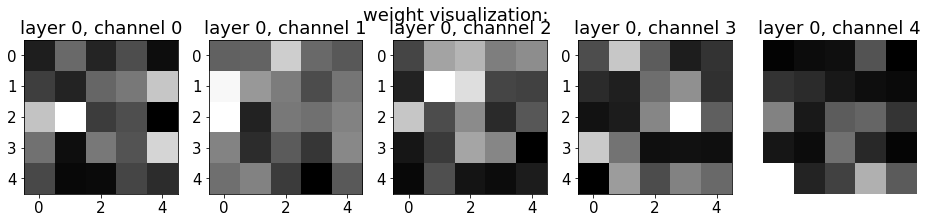

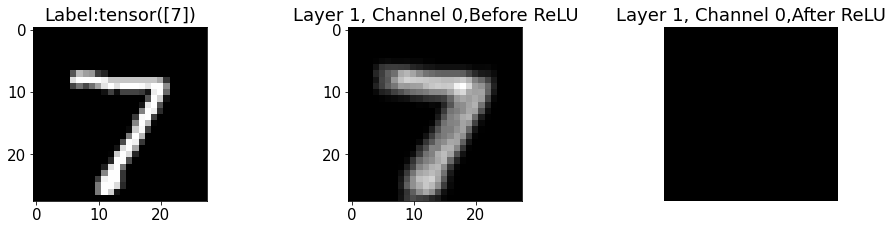

In [ ]:
model_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=32*14*14, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) # output
  )

model_3.apply(init_conv2d_weights)
model_3 = model_3.to(device)

train(model_3, conv_lr)
print_report(model_3, has_convolution=True, conv_layers_to_print=[1])

## Model 4:
- Convolution layer with 32 5x5 filters (stride=1, padding=same)
- Max-Pooling layer: 2x2 filters (stride=2)
- Convolution layer with 64 5x5 filters (stride=1, padding=same)
- Max-Pooling layer: 2x2 filters (stride=2)
- Fully connected layer with 1024 neurons + ReLU activation


time taken: 192.337 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                 [-1, 1024]       3,212,288
              ReLU-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.69


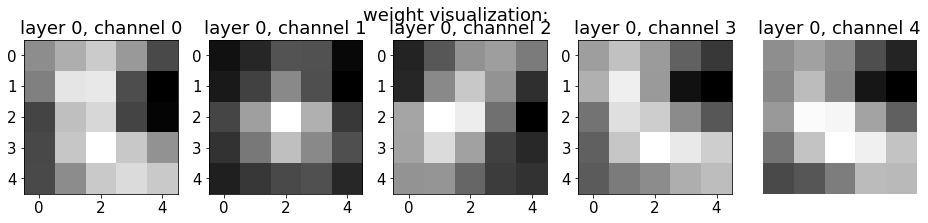

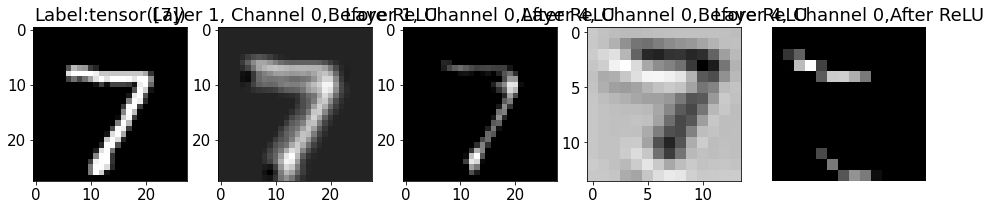

In [ ]:
model_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) # output
  )

model_4.apply(init_conv2d_weights)
model_4 = model_4.to(device)

train(model_4, conv_lr)
print_report(model_4, has_convolution=True, conv_layers_to_print=[1, 4])

## Model 5:
- Convolution layer with 32 5x5 filters (stride=1, padding=same)
- Max-Pooling layer: 2x2 filters (stride=2)
- Convolution layer with 64 5x5 filters (stride=1, padding=same)
- Max-Pooling layer: 2x2 filters (stride=2)
- Fully connected layer (dropout=0.5) with 1024 neurons + ReLU activation


part 1: with batch size 50

time taken: 192.954 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
           Dropout-8                 [-1, 3136]               0
            Linear-9                 [-1, 1024]       3,212,288
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
-------------------------------------------------------------

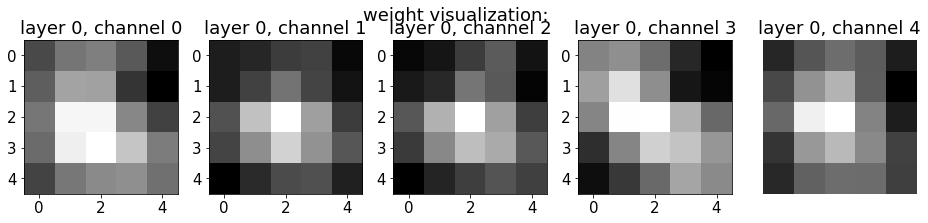

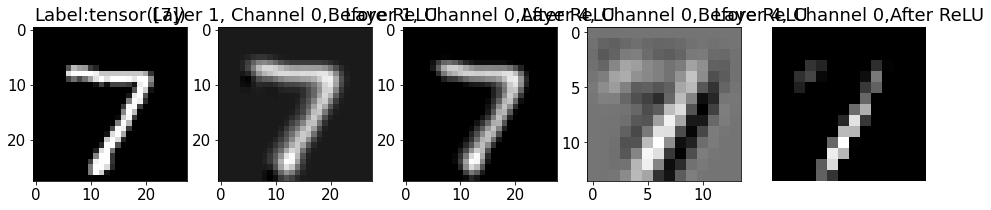

In [ ]:
model_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding="same"),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=64*7*7, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=10) # output
  )

model_5.apply(init_conv2d_weights)
model_5 = model_5.to(device)

train(model_5, conv_lr)
print_report(model_5, has_convolution=True, conv_layers_to_print=[1, 4])

part 2: with batch size 100

time taken: 146.778 second(s)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             832
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          51,264
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
           Dropout-8                 [-1, 3136]               0
            Linear-9                 [-1, 1024]       3,212,288
             ReLU-10                 [-1, 1024]               0
           Linear-11                   [-1, 10]          10,250
Total params: 3,274,634
Trainable params: 3,274,634
Non-trainable params: 0
-------------------------------------------------------------

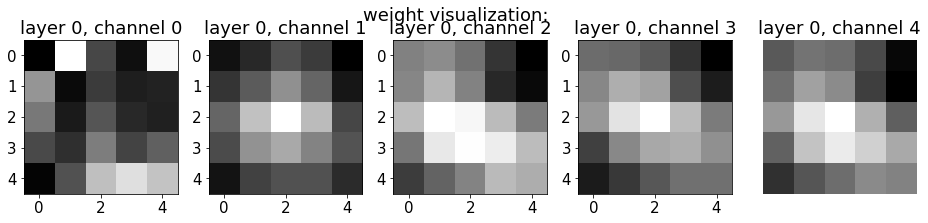

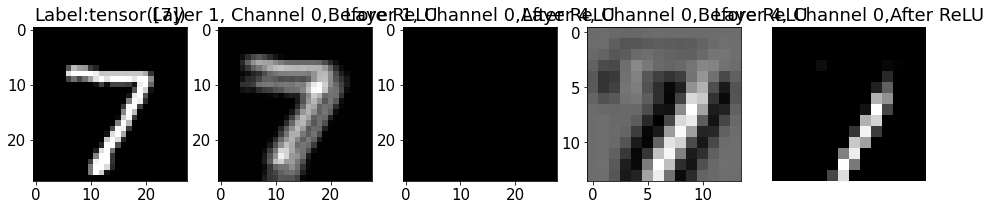

In [ ]:
train_loader = DataLoader(all_train_data,
                          batch_size=batch_size*2,
                          sampler=SubsetRandomSampler(train_indices),
                          generator=cpu_rng,
                          num_workers=1,
                          pin_memory=(device.type == "coda:0"),
                          persistent_workers=True);

def reset_net_parameters(model:nn.Sequential):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

model_5.apply(reset_net_parameters)
model_5.apply(init_conv2d_weights)

train(model_5, conv_lr)
print_report(model_5, has_convolution=True, conv_layers_to_print=[1, 4])